In [1]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

In [8]:
# Load the metadata
metadata = pd.read_csv('/Users/vrishfish/DS Project/EchoNet-Dynamic/FileList.csv')  

selected_columns = metadata[['FileName', 'EF']]
print(selected_columns)

metadata_dict = dict(zip(selected_columns['FileName'], metadata['EF']))  # Create a mapping
print(metadata_dict)

                 FileName         EF
0      0X100009310A3BD7FC  78.498406
1      0X1002E8FBACD08477  59.101988
2      0X1005D03EED19C65B  62.363798
3      0X10075961BC11C88E  54.545097
4      0X10094BA0A028EAC3  24.887742
...                   ...        ...
10025  0X234005774F4CB5CD  51.724743
10026  0X2DC68261CBCC04AE  62.187781
10027  0X35291BE9AB90FB89  62.070762
10028  0X6C435C1B417FDE8A  59.635257
10029  0X5515B0BD077BE68A  46.019994

[10030 rows x 2 columns]
{'0X100009310A3BD7FC': 78.49840597, '0X1002E8FBACD08477': 59.10198811, '0X1005D03EED19C65B': 62.36379841, '0X10075961BC11C88E': 54.54509675, '0X10094BA0A028EAC3': 24.88774165, '0X100CF05D141FF143': 55.95179045, '0X100E3B8D3280BEC5': 36.57373876, '0X100E491B3CD58DE2': 33.99174499, '0X100F044876B98F90': 69.31525203, '0X101026B90DAE7E95': 46.75519372, '0X1012703CDC1436FE': 41.01442459, '0X1013E8A4864781B': 69.20174269, '0X1018521A3BC5CDBA': 57.1235329, '0X101C388397F66EDB': 64.20806887, '0X101CFC9C5351DCBE': 55.08625176, '0X101

In [13]:
def preprocess_image_pair(directory, image_names, target_size=(224, 224)):
    """
    Loads and preprocesses the 3rd and 6th images from a directory.

    Args:
        directory (str): Path to the directory containing images.
        image_names (list): List of image names sorted in order.
        target_size (tuple): Target size for resizing the images.

    Returns:
        np.ndarray: Preprocessed and combined image pair.
    """
    # Load the 3rd and 6th images
    img3_path = os.path.join(directory, image_names[2])  # 3rd image (index 2)
    img6_path = os.path.join(directory, image_names[5])  # 6th image (index 5)

    # Load and preprocess the images
    img3 = load_img(img3_path, target_size=target_size)
    img6 = load_img(img6_path, target_size=target_size)

    # Convert to arrays and normalize
    img3 = img_to_array(img3) / 255.0
    img6 = img_to_array(img6) / 255.0

    # Stack or concatenate the images
    combined_image = np.concatenate([img3, img6], axis=-1)  # Shape: (224, 224, 6)

    return combined_image

# Root directory containing all the data
root_directory = "/Users/vrishfish/DS Project/masked_dataset"

# Initialize lists for storing processed data
image_data = []
labels = []

# Iterate over each subdirectory in the root directory
for subdir in os.listdir(root_directory):
    subdir_path = os.path.join(root_directory, subdir)
    
    # Skip if not a directory
    if not os.path.isdir(subdir_path):
        continue
    
    # List all image files in the directory and sort them
    image_names = os.listdir(subdir_path)
    print("Image names:", image_names)

    # Skip directories with fewer than 6 images
    if len(image_names) < 6:
        print(f"Skipping {subdir} - fewer than 6 images")
        continue
    
    # Preprocess the 3rd and 6th images
    combined_image = preprocess_image_pair(subdir_path, image_names)

    ef_labels = metadata_dict[subdir]
    
    # Append the processed image data
    image_data.append(combined_image)
    labels.append(ef_labels)

# Convert lists to NumPy arrays
image_data = np.array(image_data)  # Shape: (num_samples, 224, 224, 6)
labels = np.array(labels)          # Shape: (num_samples,)

print("Image data shape:", image_data.shape)
print("Labels shape:", labels.shape)








Image names: ['frame_0072_mask_2.png', 'frame_0072_mask_3.png', 'frame_0054_mask_1.png', 'frame_0054_mask_3.png', 'frame_0072_mask_1.png', 'frame_0054_mask_2.png']
Image names: ['frame_0059_mask_3.png', 'frame_0059_mask_2.png', 'frame_0059_mask_1.png', 'frame_0075_mask_1.png', 'frame_0075_mask_3.png', 'frame_0075_mask_2.png']
Image names: ['frame_0084_mask_2.png', 'frame_0084_mask_3.png', 'frame_0084_mask_1.png', 'frame_0068_mask_1.png', 'frame_0068_mask_2.png', 'frame_0068_mask_3.png']
Image names: ['frame_0090_mask_3.png', 'frame_0090_mask_2.png', 'frame_0090_mask_1.png', 'frame_0076_mask_1.png', 'frame_0076_mask_2.png', 'frame_0076_mask_3.png']
Image names: ['frame_0032_mask_3.png', 'frame_0032_mask_2.png', 'frame_0032_mask_1.png', 'frame_0056_mask_1.png', 'frame_0056_mask_2.png', 'frame_0056_mask_3.png']
Image names: ['frame_0053_mask_2.png', 'frame_0053_mask_3.png', 'frame_0053_mask_1.png', 'frame_0070_mask_3.png', 'frame_0070_mask_2.png', 'frame_0070_mask_1.png']
Image names: ['f

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2


In [26]:
# Split into training, validation, and test sets (70,15,15)
X_train, X_temp, y_train, y_temp = train_test_split(image_data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)


Training data shape: (1759, 224, 224, 6) (1759,)
Validation data shape: (377, 224, 224, 6) (377,)
Test data shape: (377, 224, 224, 6) (377,)


In [29]:
def create_model(input_shape):
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Global Average Pooling
    model.add(GlobalAveragePooling2D())

    # Fully connected layers
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # L2 regularization here
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    # Regression output layer
    model.add(Dense(1))  # Single scalar for EF

    return model

# Create the model
input_shape = (224, 224, 6)  # Input shape of the combined images
model = create_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,841 (468.13 KB)

 Trainable params: 119,393 (466.38 KB)

 Non-trainable params: 448 (1.75 KB)

In [40]:
def create_model(input_shape):
    model = Sequential()

    # Block 1
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Block 3
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Global Average Pooling
    model.add(GlobalAveragePooling2D())

    # Fully connected layers
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  # L2 regularization here
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    # Regression output layer
    model.add(Dense(1))  # Single scalar for EF

    return model

# Create the model
input_shape = (224, 224, 6)  # Input shape of the combined images
model = create_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model summary
model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 128)  │         7,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 224, 224, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,425 (404.00 KB)

 Trainable params: 102,977 (402.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [41]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 273s 5s/step - loss: 3067.3660 - mae: 53.8111 - val_loss: 3042.8877 - val_mae: 53.7182
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - loss: 1376.0229 - mae: 33.4391 - val_loss: 1938.1143 - val_mae: 42.1240
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - loss: 450.5909 - mae: 17.3893 - val_loss: 1072.2307 - val_mae: 30.5332
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - loss: 426.9693 - mae: 16.6229 - val_loss: 786.2503 - val_mae: 25.9585
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 219s 4s/step - loss: 425.3665 - mae: 16.9702 - val_loss: 679.4660 - val_mae: 23.8011
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - loss: 388.4656 - mae: 15.9236 - val_loss: 571.2867 - val_mae: 22.0995
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - loss: 393.9698 - mae: 16.3004 - val_loss: 389.9893 - val_mae: 17.9144
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 210s 4s/step - loss: 372.9511 - mae: 15.5805 - val_loss: 342.8455 - val_mae: 16.7698
Epoch 9/50


In [1]:
# Predict EF values for the test set
y_pred = model.predict(X_val)


NameError: name 'model' is not defined

In [32]:
# Evaluate on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 149.7411 - mae: 9.2905
Test Loss: 156.5043, Test MAE: 9.4633


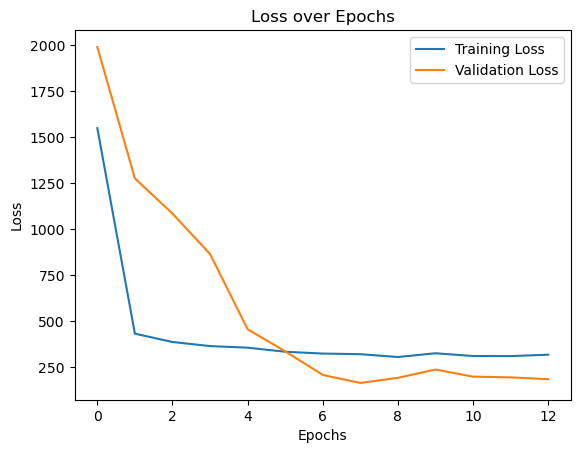

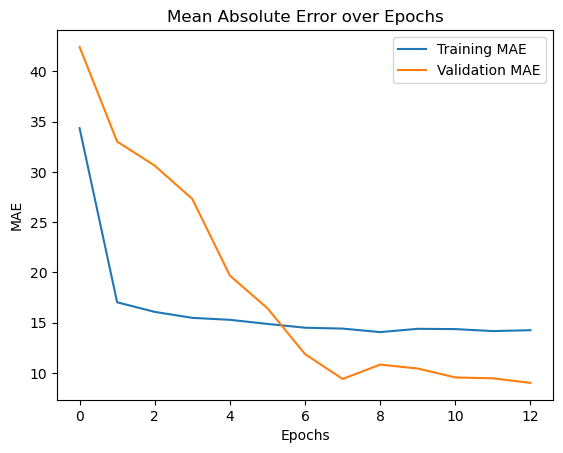

In [33]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [34]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")


RMSE: 12.3803


In [39]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape * 100:.2f}%")


MAPE: 23.20%


In [38]:
import numpy as np
from scipy.stats import pearsonr

# Ensure arrays are numeric and 1D
y_test = np.array(y_test, dtype=np.float64).flatten()
y_pred = np.array(y_pred, dtype=np.float64).flatten()

# Create the mask to filter NaN or infinite values
mask = ~np.isnan(y_test) & ~np.isnan(y_pred) & ~np.isinf(y_test) & ~np.isinf(y_pred)

# Apply the mask
y_test_clean = y_test[mask]
y_pred_clean = y_pred[mask]

# Check the cleaned data shape
print(f"Cleaned y_test shape: {y_test_clean.shape}")
print(f"Cleaned y_pred shape: {y_pred_clean.shape}")

# Ensure sufficient valid data
if len(y_test_clean) > 1:
    # Compute Pearson Correlation Coefficient
    corr, p_value = pearsonr(y_test_clean, y_pred_clean)
    print(f"Pearson Correlation Coefficient: {corr:.4f}, p-value: {p_value:.4e}")
else:
    print("Insufficient valid data to compute Pearson correlation.")


Cleaned y_test shape: (377,)
Cleaned y_pred shape: (377,)
Pearson Correlation Coefficient: -0.0253, p-value: 6.2498e-01
